# Импорт библиотек и настройка ноутбука

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import trimesh
from trimesh.voxel.creation import voxelize

import torch
from pytorch3d.io import load_obj
from pytorch3d.structures import Meshes
from pytorch3d.ops import sample_points_from_meshes
%matplotlib inline

In [2]:
# задаём устройство на котором будут производится вычисления
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  torch.cuda.set_device(device)
else:
  device = torch.device('cpu')

# Полигональная модель

In [3]:
mesh = trimesh.load('models_mesh/weapon/weapon.obj')

В компьютерной графике водонепроницаемые (watertight) сетки обычно описывают сетки, состоящие из одной замкнутой поверхности. В этом смысле водонепроницаемые сетки не содержат отверстий и имеют четко очерченную внутреннюю часть. Следовательно, они обычно требуются для многих приложений в компьютерной графике, а также в компьютерном зрении - например, при вокселизации сеток в сетки присутствия или в функциях расстояния со знаком. 

In [4]:
mesh.is_watertight

True

Эйлерова характеристика пространственного графа модели bunny Xi = V - E + F. где V, E и F - количество вершин (углов), ребер и граней в данном многограннике соответственно. Эйлерова характеристика данного графа соответствует эйлеровой хар-ки малого звездчатого додекаэдра.

In [5]:
mesh.euler_number

-6

Вывод полигональной модели

In [6]:
mesh.vertices -= mesh.center_mass # центрируем
scaling = 2 / mesh.scale 
mesh.apply_scale(scaling=scaling)

mesh.show()

# Вокселизация

In [7]:
low_idx_mesh = mesh.scale / 30
high_idx_mesh = mesh.scale / 60
vox_low_mesh = voxelize(mesh,pitch=low_idx_mesh)
vox_high_mesh = voxelize(mesh,pitch=high_idx_mesh)

print("Размер воксельной сетки с низким разрешением:", vox_low_mesh.shape)
vox_low_mesh.show()

Размер воксельной сетки с низким разрешением: (28, 7, 11)


In [8]:
print("Размер воксельной сетки с высоким разрешением:", vox_high_mesh.shape)
vox_high_mesh.show()

Размер воксельной сетки с высоким разрешением: (56, 15, 20)


# Облако точек

In [9]:
# вспомогательная функция для вывода облака точек
def plot_pointcloud(points, elev=70, azim=-70, title=""):
    # Sample points uniformly from the surface of the mesh.
    fig = plt.figure(figsize=(10, 10))
    ax = Axes3D(fig)
    x, y, z = points
    ax.scatter3D(x, z, -y,marker='.')  
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(elev, azim)
    plt.show()

In [10]:
# Загружаем вершины и грани
verts, faces_idx, _ = load_obj('models_mesh/weapon/weapon.obj')
faces = faces_idx.verts_idx

center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale
torch_mesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces.to(device)]
)

/tmp/ipykernel_28186/1940896546.py:5: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


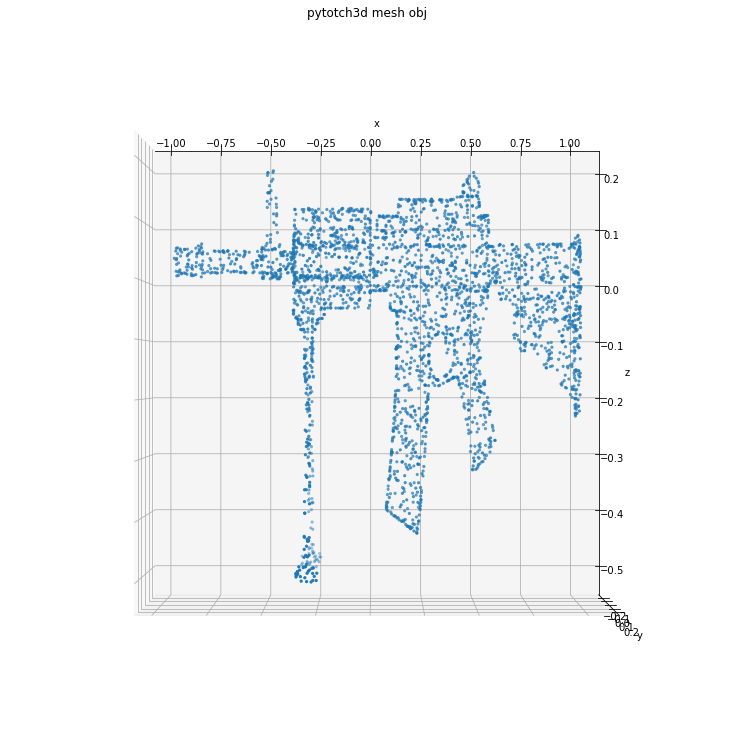

In [11]:
vert, bunny_norm = sample_points_from_meshes(meshes=torch_mesh, num_samples=3000, return_normals=True)
vert = vert.clone().detach().cpu().squeeze().unbind(1)
plot_pointcloud(vert, elev=90, azim=270, title='pytotch3d mesh obj')

# Генерация облака точек

/tmp/ipykernel_28186/3351010297.py:9: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


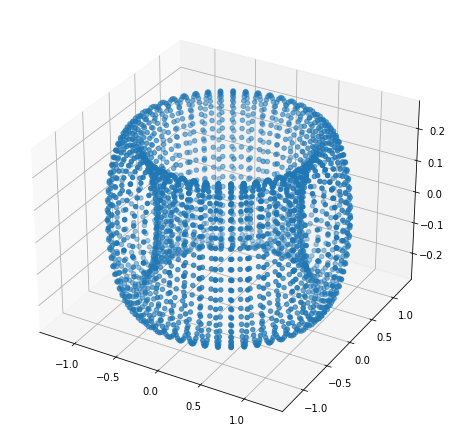

In [12]:
angle = np.linspace(0, 2 * np.pi, 50)
theta, phi = np.meshgrid(angle, angle)
r, R = .25, 1.
x= (R + r * np.cos(phi)) * np.cos(theta)
y = (R + r * np.cos(phi)) * np.sin(theta)
z = r * np.sin(phi)

fig = plt.figure(figsize=(6,15))
ax = Axes3D(fig)
ax.scatter3D(x, y, z)
plt.show()